# 05.02 Feature  Selection KBest with ANOVA F-value Score Function

Goal: identify the factors that most contribute to SLAFail

Tuning Adjustments: Focus on finding the most predictive set of predictor variables

Read Prepared Data  ->  Split Data  -> Develop Pipeline  ->  Evaluate  

Split Data using sklearn.model_selection.train_test_split

Pipeline includes:

- Preprocessing variables
    - sklearn.compose.make_column_transformer 
    - Scale numeric variables: sklearn.preprocessing.StandardScaler
    - Encode categorical variables: category_encoders.MEstimateEncoder
- Selecting features
    - sklearn.feature_selection.SelectKBest
    - sklearn.feature_selection.f_classif
- Instantiate model
    - sklearn.linear_model.LogisticRegression
- Fit the model using training data
- Cross-validate the model with training data
    - sklearn.model_selection.cross_val_score
- Output performance measures

Evaluate involves running the pipeline with the testing data and capturing metrics





In [1]:
# Load libraries
import pandas as pd
import numpy as np
import pickle

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn import metrics

## Read Prepared Data

In [2]:
df = pd.read_csv("data/04.a.Detail_Incident_AtOpen.csv")
print("df.shape: " + str(df.shape))
print("df.columns: " + str(df.columns))
print("df.dtypes: \n" + str(df.dtypes))

df.shape: (35208, 12)
df.columns: Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'SLAFail', 'Open_Time_HourOfDay',
       'Open_Time_DayOfWeek', 'CI_TypeSubType_aff'],
      dtype='object')
df.dtypes: 
CI_Name_aff                    object
Service_Component_WBS_aff      object
Impact                         object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
SLAFail                         int64
Open_Time_HourOfDay             int64
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object


#### Set X and y

In [3]:
y = df.SLAFail
y.shape

(35208,)

In [4]:
X = df.drop(['SLAFail'], axis='columns')
X.shape

(35208, 11)

Set `Open_Time_HourOfDay` for recognition as a Categorical variable

In [5]:
X.Open_Time_HourOfDay = X.Open_Time_HourOfDay.astype('object')
X.dtypes

CI_Name_aff                    object
Service_Component_WBS_aff      object
Impact                         object
Urgency                        object
KM_number                      object
Count_Related_Interactions    float64
Count_Related_Incidents       float64
Count_Related_Changes         float64
Open_Time_HourOfDay            object
Open_Time_DayOfWeek            object
CI_TypeSubType_aff             object
dtype: object

Create a list of numeric variable column names

In [6]:
numericVars = X.select_dtypes(include=['float64']).columns
numericVars

Index(['Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes'],
      dtype='object')

Create a list of categorical variables

In [7]:
categoricalVars = X.select_dtypes(include=['object']).columns
categoricalVars

Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')

## Split Data

Create Training and Testing Data Sets


In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)


In [9]:
print(X_train.shape)
print(X_train.columns)

(24645, 11)
Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Count_Related_Interactions', 'Count_Related_Incidents',
       'Count_Related_Changes', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')


## Develop Pipeline


In [10]:
# create dictionary to store information about the pipeline and results for later reporting and review
PipeLineMetadata = { "Name" : "Feature Selection KBest F-Classif" }

### Encode Variables

Numeric and categorical variables require different treatment 

Set up column transformer for scaling numeric variables and encoding categorical variables



In [11]:
column_trans = make_column_transformer(
    (ce.WOEEncoder(), categoricalVars),
    (StandardScaler(), numericVars),
    remainder='passthrough')

In [12]:
column_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('woeencoder',
                                 WOEEncoder(cols=None, drop_invariant=False,
                                            handle_missing='value',
                                            handle_unknown='value',
                                            random_state=None, randomized=False,
                                            regularization=1.0, return_df=True,
                                            sigma=0.05, verbose=0),
                                 Index(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Open_Time_HourOfDay', 'Open_Time_DayOfWeek',
       'CI_TypeSubType_aff'],
      dtype='object')),
                                ('standardscaler',
                                 StandardScaler(copy=True, with_mean=True,
                                      

### Feature Selection




In [13]:
selector = SelectKBest(score_func=f_classif, k=10)

### Specify Classifier (Logistic Regression)

In [14]:
classifier = LogisticRegression(solver="lbfgs")

### Compose Pipeline

In [15]:
pipe = make_pipeline(column_trans, 
                     selector,
                     classifier)

### Fit the Model Using the Pipeline

In [16]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('woeencoder',
                                                  WOEEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             random_state=None,
                                                             randomized=False,
                                                             regularization=1.0,
                                                             return_df=True,
                                           

### Capture model  information

In [17]:
PipeLineMetadata['Column Transforms'] = list(pipe.named_steps.columntransformer.named_transformers_.keys())
PipeLineMetadata['Selector'] = pipe.named_steps.selectkbest.get_params
PipeLineMetadata['Classifier'] = pipe.named_steps.logisticregression
PipeLineMetadata

{'Name': 'Feature Selection KBest F-Classif',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Selector': <bound method BaseEstimator.get_params of SelectKBest(k=10, score_func=<function f_classif at 0x1a205f5830>)>,
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

Identify the features retained

In [18]:
pipe.named_steps.selectkbest.scores_

array([4.04035978e+03, 2.62605572e+03, 1.40220303e+02, 1.41583607e+02,
       6.10443839e+03, 1.77755544e+02, 6.79762696e+02, 9.02108720e+02,
       6.20757993e+01, 5.60722172e+00, 3.51935177e-01])

In [19]:
pipe.named_steps.selectkbest.pvalues_

array([0.00000000e+000, 0.00000000e+000, 2.91451608e-032, 1.47282598e-032,
       0.00000000e+000, 2.06821476e-040, 7.61382496e-148, 1.10035990e-194,
       3.44070391e-015, 1.78942746e-002, 5.53025157e-001])

In [20]:
PipeLineMetadata['Selector - Scores'] = pd.DataFrame([pipe.named_steps.selectkbest.scores_, pipe.named_steps.selectkbest.pvalues_], columns=X_train.columns, index=['scores','p-value']).transpose().sort_values(by=['p-value'])
PipeLineMetadata

{'Name': 'Feature Selection KBest F-Classif',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Selector': <bound method BaseEstimator.get_params of SelectKBest(k=10, score_func=<function f_classif at 0x1a205f5830>)>,
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Selector - Scores':                                  scores        p-value
 CI_Name_aff                 4040.359780   0.000000e+00
 Service_Component_WBS_aff   2626.055718   0.000000e+00
 KM_number                   6104.438394   0.000000e+00
 Count_Related_Changes        902.108720  1.100360e-194
 Count_Related_Incidents      679.762696  7.613825e-148
 Count_Related_Interactions   177.755544   2.068215e-40
 Urgency       

In [21]:
# returns a mask of features retained
pipe.named_steps.selectkbest.get_support().tolist()

[True, True, True, True, True, True, True, True, True, True, False]

In [22]:
# apply mask to X_train column names 
selectedFeatures = np.array(X_train.columns.tolist())[pipe.named_steps.selectkbest.get_support().tolist()]
selectedFeatures

array(['CI_Name_aff', 'Service_Component_WBS_aff', 'Impact', 'Urgency',
       'KM_number', 'Count_Related_Interactions',
       'Count_Related_Incidents', 'Count_Related_Changes',
       'Open_Time_HourOfDay', 'Open_Time_DayOfWeek'], dtype='<U26')

In [23]:
PipeLineMetadata['Classifier - Intercept'] = pipe.named_steps.logisticregression.intercept_[0]
PipeLineMetadata['Classifier - Coefficients'] = pd.DataFrame(pipe.named_steps.logisticregression.coef_, columns=selectedFeatures).transpose()
PipeLineMetadata

{'Name': 'Feature Selection KBest F-Classif',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Selector': <bound method BaseEstimator.get_params of SelectKBest(k=10, score_func=<function f_classif at 0x1a205f5830>)>,
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Selector - Scores':                                  scores        p-value
 CI_Name_aff                 4040.359780   0.000000e+00
 Service_Component_WBS_aff   2626.055718   0.000000e+00
 KM_number                   6104.438394   0.000000e+00
 Count_Related_Changes        902.108720  1.100360e-194
 Count_Related_Incidents      679.762696  7.613825e-148
 Count_Related_Interactions   177.755544   2.068215e-40
 Urgency       

## Cross-validate the Model with Training Data


In [24]:
PipeLineMetadata['Metrics - Cross Validation Accuracy'] = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()
PipeLineMetadata

{'Name': 'Feature Selection KBest F-Classif',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Selector': <bound method BaseEstimator.get_params of SelectKBest(k=10, score_func=<function f_classif at 0x1a205f5830>)>,
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Selector - Scores':                                  scores        p-value
 CI_Name_aff                 4040.359780   0.000000e+00
 Service_Component_WBS_aff   2626.055718   0.000000e+00
 KM_number                   6104.438394   0.000000e+00
 Count_Related_Changes        902.108720  1.100360e-194
 Count_Related_Incidents      679.762696  7.613825e-148
 Count_Related_Interactions   177.755544   2.068215e-40
 Urgency       

## Evaluate with Test Data

Get predicted classification and predicted probabilities based on the model

In [25]:
y_pred_class = pipe.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)[:,1]

In [26]:
PipeLineMetadata['Metrics - F1 score'] = metrics.f1_score(y_test, y_pred_class, average='macro')
PipeLineMetadata['Metrics - F1 score']

0.6579221552692892

Look at the resulting confusion matrix

Save True Positive (TP), True Negative (TN), False Positive(FP), and False Negative (FN) values

In [27]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)
print("TN: %d \t FP: %d \nFN: %d \t TP: %d " % (TN, FP, FN, TP))

[[6581  864]
 [1839 1279]]
TN: 6581 	 FP: 864 
FN: 1839 	 TP: 1279 


Capture a few classification metrics:
* Classification Accuracy: Overall, how often is the classifier correct?
* Classification Error: Overall, how often is the classifier incorrect?
* True Positive Rate  (Recall, Sensitivity): When the actual value is positive, how often is the prediction correct?
* True Negative Rate (Specificity): When the actual value is negative, how often is the prediction correct?
* False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
* Precision: When a positive value is predicted, how often is the prediction correct?


In [28]:
PipeLineMetadata['Metrics - Confusion Matrix Classification Accuracy'] = metrics.accuracy_score(y_test,y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix Classification Error'] = 1- metrics.accuracy_score(y_test,y_pred_class)
PipeLineMetadata['Metrics - Confusion Matrix True Positive Rate'] = metrics.recall_score(y_test, y_pred_class) 
PipeLineMetadata['Metrics - Confusion Matrix True Negative Rate'] =  TN / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix False Positive Rate'] =  FP / float(TN + FP)
PipeLineMetadata['Metrics - Confusion Matrix Precision'] = metrics.precision_score(y_test,y_pred_class)

In [29]:
PipeLineMetadata


{'Name': 'Feature Selection KBest F-Classif',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Selector': <bound method BaseEstimator.get_params of SelectKBest(k=10, score_func=<function f_classif at 0x1a205f5830>)>,
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Selector - Scores':                                  scores        p-value
 CI_Name_aff                 4040.359780   0.000000e+00
 Service_Component_WBS_aff   2626.055718   0.000000e+00
 KM_number                   6104.438394   0.000000e+00
 Count_Related_Changes        902.108720  1.100360e-194
 Count_Related_Incidents      679.762696  7.613825e-148
 Count_Related_Interactions   177.755544   2.068215e-40
 Urgency       

Add some ROC curve information and AUC result


In [30]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

In [31]:
PipeLineMetadata['Metrics - ROC Curve fpr array'] = fpr
PipeLineMetadata['Metrics - ROC Curve tpr array'] = tpr

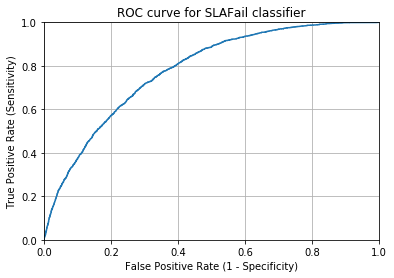

In [32]:
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SLAFail classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Capture resulting AUC

In [33]:
PipeLineMetadata['Metrics - AUC'] = metrics.roc_auc_score(y_test, y_pred_prob)
print("Metrics = AUC: %f " % PipeLineMetadata['Metrics - AUC']) 

Metrics = AUC: 0.780698 


## Save Details and Performance Measures for Comparison to other Models


In [34]:
PipeLineMetadata

{'Name': 'Feature Selection KBest F-Classif',
 'Column Transforms': ['woeencoder', 'standardscaler'],
 'Selector': <bound method BaseEstimator.get_params of SelectKBest(k=10, score_func=<function f_classif at 0x1a205f5830>)>,
 'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'Selector - Scores':                                  scores        p-value
 CI_Name_aff                 4040.359780   0.000000e+00
 Service_Component_WBS_aff   2626.055718   0.000000e+00
 KM_number                   6104.438394   0.000000e+00
 Count_Related_Changes        902.108720  1.100360e-194
 Count_Related_Incidents      679.762696  7.613825e-148
 Count_Related_Interactions   177.755544   2.068215e-40
 Urgency       

In [35]:
with open("data/05.02.a Feature Select KBest f_classif.pkl",'wb') as fo:
    pickle.dump(PipeLineMetadata, fo)

In [36]:
# with open("FILENAME", 'rb') as fi:
#    BareBonesMetadata = pickle.load(fi)